# Pre-processing

This script does all the image pre-processing: opens .fits files and selects appropriate layer, standardises the pixel values to have mean 0 and std 1, opens files with centre values in, calculates each image's anchors labels. Saves dataset in the .hdf5 format. (Also functions to write data in .npy format, either as seperate files for each image or files stack with all images, these functions are old and not called)

All this pre-processing saves time in training the open because these operations only have to be performed once here, and hence aren't repeated.

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pandas as pd
from tqdm import tqdm
import h5py

In [2]:
def pad_fits(start,num,path):
    """
    Functions to add extra padding to file names. Essentially I decided I 
    needed more than 9999 files but had already generated all these so 
    instead of re-runing their generation I decided to simply pad a
    0 to their values
    """
    os.chdir(path)
    for i in range(start,num):
        if os.path.isfile(('test_'+f'{i:04}'+'.fits')):
            os.rename(('test_'+f'{i:04}'+'.fits'),('test_'+f'{i:05}'+'.fits'))
    return 

def pad_csv(start,num,path):
    """
    Functions to add extra padding. Essentially I decided I needed
    more than 9999 files but had already generated all these so 
    instead of re-runing their generation I decided to simply pad a
    0 to their values
    """
    os.chdir(path)
    
    for i in range(start,num):
        if os.path.isfile(('test_'+f'{i:04}'+'.csv')):
            print(i)
            os.rename(('test_'+f'{i:04}'+'.csv'),('test_'+f'{i:05}'+'.csv'))
    return

#pad_fits(0,9999,"/Users/edroberts/Desktop/im_gen/training_data/train/fits")
#pad_csv(0,9999,"/Users/edroberts/Desktop/im_gen/training_data/train/csv")

In [3]:
def find_files(expected_number, path, name_type):
    """
    Function to make a list of all files that exist.
    
    Gets around missing data in dataset instead of painfully
    going through and regenerating.
    
    The bug in the generation python script appears to be when
    the max/min number of galaxies are reached.
    
    It is quicker to simply ignore missing data than sorting 
    out the perculiar bug. The total number of images doesn't 
    necessarily need to be any number, however should be split in 
    batches which are a power of 2.
    """
    actual_file_numbers = []
    missing_file_numbers = []
    os.chdir(path)
    
    count = 0
    for i in range(expected_number):
        if os.path.isfile((name_type+'_'+f'{i:05}'+'.fits')):
            count += 1
            actual_file_numbers.append(f'{i:05}')
        else:
            missing_file_numbers.append(f'{i:05}')
    
    return actual_file_numbers, missing_file_numbers

In [4]:
def open_fits(file_list_numbers, pixel_x, pixel_y,path, name_type):
    """
    Function to open .fits files and select image layer
    """
    data_images = np.zeros((len(file_list_numbers),1,pixel_y,pixel_x))

    #moving to right directory
    os.chdir(path)
    
    print("OPENING FITS...")
    
    # Opening an selecting appropriate .fits layer
    for count, i in enumerate(file_list_numbers):
        #print("Count: "+str(count)+" file num: " +str(i))
        with fits.open(name_type+'_'+i+'.fits') as hdul:
            #hdul.info()
            data_images[count] = np.array(hdul[1].data);
            
    print("SUCCESSFULLY OPENED FITS \n")
    
    return data_images

In [5]:
def standardise_images(data_images,pixel_y,pixel_x):
    """
    Function to rescale the pixel values of 
    an image to have mean 0 and standard
    deviation 1
    """
    
    img_std = np.zeros((len(data_images),1,pixel_y,pixel_x))
    
    print("STANDARDISING PIXEL VALUES...")
    
    for i in tqdm(range(len(data_images))):
        mean = np.mean(data_image[i])
        std = np.std(data_image[i])
        img_std[i] = (data_image[i]-mean)/std
        
    print("STANDARDISATION COMPLETE \n")
        
    return img_std

In [6]:
def get_anchors(config):
    """
    Generates a lattice of anchors for a given image input
    size and feature map size. Note the coordinates are 
    (x,y) indexed!
    
    Adapted from Duncan Tilley's work on PPN 
    https://github.com/tilleyd/point-proposal-net/
    
    config
        The configuration dictionary.

    Returns the coorinates of the origin anchors (x,y).
    
    """
    
    # Reads sizes
    img_size = config['image_size']
    feature_size = config['feature_size']
    
    # Calculates step length for given sizes
      d i  s p l  a  y                 
    halfstep = step * 0.5
    
    # Calculates the lattice of points
    x = np.arange(halfstep, img_size, step, dtype=np.float32)
    y = np.arange(halfstep, img_size, step, dtype=np.float32)
    
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])


def get_anchor_labels(anchors, truth_coords, config):
    """
    Creates anchor labels to be used in training.
    
    Adapted from Duncan Tilley's work on PPN 
    https://github.com/tilleyd/point-proposal-net/
    
    anchors
        The list of anchor coordinates generated from 
        get_anchors()
    
    truth_coords
        The list of ground truth point cooridnates.
        Using (x,y) convention.
    
    config
        The configuration dictionary.
    
    Returns y_conf, y_reg with shape (7,7), (2,7,7) 
    """

    r_near = config['r_near']
    r_far = config['r_far']
    img_size = config['image_size']
    feature_size = config['feature_size']
    
    step = img_size / feature_size
    halfstep = step * 0.5

    # Initialising output
    y_conf = np.full(anchors.shape[0], -1, dtype=np.int8)
    y_reg = np.zeros(anchors.shape)
    
    # For each true point, find the nearest anchor
    for (x, y) in truth_coords:
        
        # Normalising truth points to step size
        x_norm = (x - halfstep) / step
        y_norm = (y - halfstep) / step
        
        # Finding index of closest anchor by rounding
        r = int(np.round(y_norm))
        c = int(np.round(x_norm))   
        anchor_index = r * feature_size + c
        
        # Setting values for anchor index
        y_conf[anchor_index] = 1
        y_reg[anchor_index][0] = (x - anchors[anchor_index][0]) / step
        y_reg[anchor_index][1] = (y - anchors[anchor_index][1]) / step
    
    # For each anchor calculate the distance to each point
    for i in range(len(anchors)):
        x, y = anchors[i]
        x /= step
        y /= step
        distances = []
        for (px, py) in truth_coords:
            px /= step
            py /= step
            distances.append(np.sqrt((x-px)**2 + (y-py)**2))
        
        if len(distances) > 0:
            near = np.argmin(distances)
            dist = distances[near]
            
            if dist <= r_near:
                y_conf[i] = 1
                px, py = truth_coords[near]
                
                px /= step
                py /= step
                
                y_reg[i][0] = (px - x)
                y_reg[i][1] = (py - y)
                
            elif dist > r_far:
                y_conf[i] = 0
                
    # reshape for use in PPN training
    y_conf = np.reshape(y_conf, (feature_size, feature_size))
    y_reg = np.reshape(y_reg, (feature_size, feature_size) + (2,))
    y_reg = np.transpose(y_reg, (2, 0, 1))
    
    return y_conf, y_reg


In [7]:
def open_and_label_centres(path_main, path_csv, conf_array, reg_array, file_list, config):
    """
    Function to open centres .csv files for each image and then 
    pass centre coordinates to get_anchor_labels so that we get
    ground truth labesl for each image.
    
    Also calculates and saves anchors
    """
    # Note ordering only works up to 99999 as numbers on file names padded to 00000
    csvdir_path = pathlib.Path(path_csv)
    csv_file_list = sorted([str(path) for path in csvdir_path.glob('*.csv')])
    
    
    # Define origin anchor positions and save to "anchors.npy" file
    anchors = get_anchors(config)
    os.chdir(path_main)
    np.save("anchors",anchors)
    
    print("CALCULATING LABELS... ")
    
    # For each image, read the file with centre locations 
    for i in tqdm(range(len(file_list))):
        df_center = pd.read_csv(csv_file_list[i], sep=',', header=None)
        np_center = df_center.values
        np_center[[0,1]] = np_center[[1,0]] # Swapping from y,x to x,y
        
        # Remember .T for np_centers file to transpose from collumns to rows
        conf_labels[i], reg_labels[i] = get_anchor_labels(anchors, np_center.T, config)

    print("LABELS DONE \n")
    
    return anchors, conf_array, reg_array

In [8]:
def write_HDF5(path, name, image_array, conf_array, reg_array):
    """
    Function to write the dataset to HDF5 format
    """
    if len(image_array) != len(conf_labels):
        return "ERROR length image_array != conf_labels"
    
    if len(image_array) != len(reg_labels):
        return "ERROR length image_array != reg_labels"
    
    if len(conf_array) != len(reg_labels):
        return "ERROR length conf_array != reg_labels"
    
    print("WRITING HDF5 FILE...")
    
    os.chdir(path)
    with h5py.File(name+'.hdf5', 'w') as f:
        dset_images = f.create_dataset("images", data=image_array)
        dset_conf = f.create_dataset("confidence", data=conf_array)
        dset_reg = f.create_dataset("regression", data=reg_array)
        
    print("HDF5 datafile written")
    return 


In [9]:
def save_single_images(image_array, file_names ,base_path):
    """
    !!!Retired function: now using hdf5!!!
    
    Function to save images as individual files
    """
    
    os.chdir(base_path)
    
    if not os.path.isfile(('/images')):
        os.mkdir(base_path+"/images");
    os.chdir(base_path+"/images");
    
    for i in range(len(image_array)):
        np.save(file_names[i]+"_im", image_array[i])
        
        
def save_stack_images(image_array, base_path, name):
    """
    !!!Retired function: now using hdf5!!!
    
    Save images all in one stacked npy file
    """
    os.chdir(base_path)
    np.save(name,image_array)
    
    
def write_label_npy(path, main_name, conf_array, reg_array):
    """
    !!!Retired function: now using hdf5!!!
    
    Function to write data as npy files.
    
    Each label data is stored in sepearte npy file
    """
    for i in tqdm(range(len(conf_array))):
        if i == 0:
            os.mkdir(dir_path+"/anchor_labels");
        os.chdir(dir_path+"/anchor_labels");
        
        np.save(main_name+"_conf",conf_array[i])
        np.save(main_name+"_reg",reg_array[i])
        
    return

In [10]:
test_config = {
    "image_size": 224,
    "feature_size": 7,
    "r_far": np.sqrt(0.5*0.5 + 0.5*0.5),
    "r_near": np.sqrt(0.5*0.5 + 0.5*0.5),
    "batch_size": 128
    
}

prepros_config = {
    "path_to_fits": '/Users/edroberts/Desktop/im_gen/training_data/train/fits',
    "path_to_csv": '/Users/edroberts/Desktop/im_gen/training_data/train/csv',
    "path_to_main": '/Users/edroberts/Desktop/im_gen/training_data/train',
    "image_name": 'train',
    "hdf5_name": 'dataset',
    "expected_img_number": 30093
}

In [11]:
# MAIN

files , missing_files = find_files(prepros_config["expected_img_number"], 
                                   prepros_config['path_to_fits'], 
                                   prepros_config['image_name'])

print("Total number of images in the dataset is: " + str(len(files)) + "\n")



data_image = open_fits(files,
                       test_config['image_size'],
                       test_config['image_size'],
                       prepros_config['path_to_fits'],
                       prepros_config['image_name'])

std_image = standardise_images(data_image,
                               test_config['image_size'],
                               test_config['image_size'])



conf_labels = np.full((len(files), 1, test_config['feature_size'],
                       test_config['feature_size']), -1, dtype=np.float64)

reg_labels = np.full((len(files), 2, test_config['feature_size'],
                    test_config['feature_size']), -1, dtype=np.float64)


anchors, conf_labels, reg_labels = open_and_label_centres(prepros_config['path_to_main'], 
                                                          prepros_config['path_to_csv'],
                                                          conf_labels, reg_labels, files, 
                                                          test_config)



write_HDF5(prepros_config['path_to_main'], prepros_config['hdf5_name'], std_image, conf_labels, reg_labels)

Total number of images in the dataset is: 29824

OPENING FITS...
SUCCESSFULLY OPENED FITS 

STANDARDISING PIXEL VALUES...


100%|████████████████████████████████████| 29824/29824 [01:30<00:00, 330.01it/s]


STANDARDISATION COMPLETE 

CALCULATING LABELS... 


100%|████████████████████████████████████| 29824/29824 [00:49<00:00, 602.46it/s]


LABELS DONE 

WRITING HDF5 FILE...
HDF5 datafile written


In [16]:
########################################################################
# Testing Code 
########################################################################

In [12]:
print(conf_labels[1])

[[[0. 0. 1. 0. 1. 0. 1.]
  [0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 0. 1. 0. 0.]
  [1. 1. 1. 0. 1. 1. 0.]]]


In [13]:
print(reg_labels[1])

[[[ 0.       0.      -0.34375  0.      -0.21875  0.      -0.09375]
  [ 0.      -0.0625   0.34375 -0.65625 -0.21875 -0.03125 -0.3125 ]
  [ 0.       0.       0.       0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.       0.       0.       0.     ]
  [ 0.       0.4375  -0.5625   0.      -0.3125   0.       0.     ]
  [ 0.3125  -0.6875   0.25     0.       0.375   -0.625    0.     ]]

 [[ 0.       0.       0.3125   0.       0.53125  0.      -0.09375]
  [ 0.       0.03125 -0.0625  -0.0625  -0.46875 -0.21875 -0.15625]
  [ 0.       0.       0.       0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.       0.       0.       0.     ]
  [ 0.       0.125    0.125    0.      -0.21875  0.       0.     ]
  [ 0.09375  0.09375 -0.21875  0.      -0.125   -0.125    0.     ]]]


In [6]:
# Testing to see if .hdf5 written correctly
x=1
os.chdir('/Users/edroberts/Desktop/im_gen/training_data/train')
with h5py.File('dataset.hdf5', 'r') as f:
    image = f['images'][x]
    conf = f['confidence'][x]
    reg = f['regression'][x]
    
print(image)
print(conf)
print(reg)

[[[-7.43697702e-01  7.47213505e-02  5.80275532e-04 ... -4.21049533e-01
   -2.64094733e-01 -9.04092544e-01]
  [ 1.60494417e-01 -3.37417740e-01 -1.52784548e-01 ... -2.02557245e-02
    7.10716564e-03 -1.09733670e-01]
  [-1.37637574e-01 -3.08360830e-01 -1.66486455e-01 ... -7.33495881e-03
   -1.38798094e-01 -4.21471036e-01]
  ...
  [-9.00132065e-02 -3.78478240e-01  7.20108293e-02 ... -9.17051004e-01
   -6.21540302e-01 -7.25207750e-01]
  [-1.16144576e-01 -6.30424141e-01 -7.34811653e-01 ... -4.59396359e-02
   -3.35438794e-01  7.99345842e-02]
  [-7.43160374e-01 -1.95464234e-01 -6.97024824e-01 ... -1.36553410e-01
   -7.52544821e-02 -3.83026646e-01]]]
[[[0. 0. 1. 0. 1. 0. 1.]
  [0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 0. 1. 0. 0.]
  [1. 1. 1. 0. 1. 1. 0.]]]
[[[ 0.       0.      -0.34375  0.      -0.21875  0.      -0.09375]
  [ 0.      -0.0625   0.34375 -0.65625 -0.21875 -0.03125 -0.3125 ]
  [ 0.       0.       0.       0.      

In [8]:
os.chdir('/Users/edroberts/Desktop/im_gen/training_data/train')
with h5py.File('dataset.hdf5', 'r') as f:
    conf_shape = f['confidence'].shape
    
print(conf_shape[0])

19821


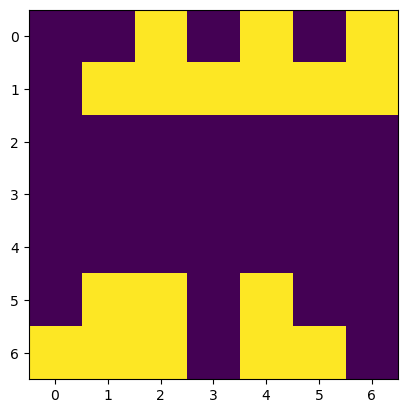

In [37]:
plt.imshow(conf_labels[1][0])

In [ ]:
basename = os.path.splitext(os.path.basename(csv_file_list[i]))[0]